# GPy(GPregression)に関する備忘録
- GPRegressionをベイズ的に使うためのTips
  - hyperparametersに対するPrior設定法
  - MCMCによるhyperparameter推定法
  - 結果の様々なplot方法

# 0. Install
- (2019.05時点で)python3.7で"pip install GPy"しようとするとエラーが出ることがある。
  - python3.6用の環境を別に用意する方が無難。
- 加えてpipからinstallした場合、GPyのmodel.plot()が機能しないことがあった。
  - "conda install -c conda-forge gpy"を推奨。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import GPy

In [2]:
plt.style.use('ggplot')
np.random.seed(0)

# 1. Data
- 前回"GP&TPonSinWave"と同じものを使う。

In [3]:
X = np.arange(-5,5,0.5)
truY = np.sin(X)
Y = truY + np.random.normal(loc=0, scale=0.1, size=X.shape[0])
X_new = np.arange(-7,7,0.05)

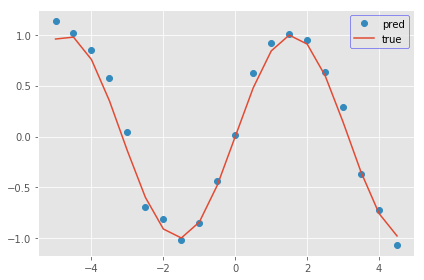

In [4]:
fig, ax = plt.subplots()
ax.plot(X, Y, color="C1", label="pred", marker="o", linestyle="")
ax.plot(X, truY, color="C0", label="true")
ax.legend(edgecolor="b")
fig.tight_layout()

# 2. Model
- 最も使用機会が多いであろう、GPRegressionベースで検討する。
  - GPと異なり、デフォルトでガウス分布に従う観測ノイズ("Gaussian_noise")が設定されている。
  - 用意されていないモデル（ポワソン回帰etc.）を定義したい場合はGPから構築することになる。ポワソン回帰の例は<http://statmodeling.hatenablog.com/entry/how-to-use-GPy>に紹介されている。

 /anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


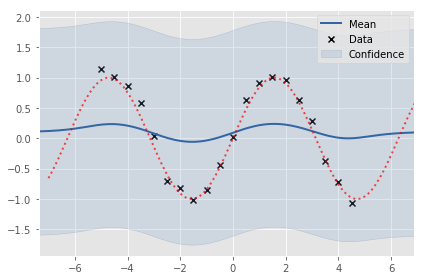

In [5]:
kern = GPy.kern.Matern52(input_dim=1, ARD=True)
gpmodel = GPy.models.GPRegression(X.reshape((-1,1)), Y.reshape((-1,1)), kernel=kern, normalizer=True)
gpmodel.randomize()
gpmodel.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

1. 入力データの次元(input_dim)を1に設定。1次元なのでARDには意味がないが、多次元であれば各次元ごとにlengthscaleが設定される。
2. モデル定義。注意点はデータをndim=2に設定する必要があること。
3. hyperparameterの初期値を乱数設定している。

In [6]:
gpmodel

GP_regression.,value,constraints,priors
Mat52.variance,0.07496698473222704,+ve,
Mat52.lengthscale,1.0724342655855537,+ve,
Gaussian_noise.variance,1.2160004114647829,+ve,


# 3. Priors
- hyperparameterに事前分布を設定するには、
  1. GPy.priorsから事前分布を選択する。
  2. set_prior()により特定のhyperparameterに設定する。

In [7]:
norm = GPy.priors.Gaussian(mu=0, sigma=1)

ここで定義したガウス事前分布を、観測ノイズのvarianceに対して設定したい。

In [8]:
param_name = gpmodel.parameter_names()
print(param_name[2])
gpmodel[param_name[2]].set_prior(norm)

Gaussian_noise.variance


AssertionError: Domain of prior and constraint have to match, please unconstrain if you REALLY wish to use this prior

- priorのdomainが違うと警告が出た。  
  - 改めてgpmodelのconstaintsの欄を見ると"ve+", すなわち正の実数値に制約されていることがわかる。
  - 一方で事前分布側のdomainを確認すると…

In [9]:
norm.domain

'real'

これを正の実数に制約すれば良い。

In [10]:
norm.domain = "positive"
gpmodel[param_name[2]].set_prior(norm)
gpmodel

reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


GP_regression.,value,constraints,priors
Mat52.variance,0.07496698473222704,+ve,
Mat52.lengthscale,1.0724342655855537,+ve,
Gaussian_noise.variance,1.2160004114647829,+ve,"N(0, 1)"


- これは半正規分布による制約に相当する(はず)。
  - これでは強すぎるので、半t分布による制約に変更したい。

In [11]:
halft = GPy.priors.HalfT(nu=4, A=1)

TypeError: object() takes no parameters

- 何度か試行したが、このHalfTやInverse_Gammaは定義しようとするとエラーが出る。
  - GPy側の問題？
- やむを得ないので、StudentTのDomainを上書きして代用する。

In [12]:
halft = GPy.priors.StudentT(mu=0, sigma=0.3, nu=4)
halft.domain = "positive"
gpmodel[param_name[2]].set_prior(halft)
gpmodel

reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


GP_regression.,value,constraints,priors
Mat52.variance,0.07496698473222704,+ve,
Mat52.lengthscale,1.0724342655855537,+ve,
Gaussian_noise.variance,1.2160004114647829,+ve,"St(0, 0.3, 4)"


# 4. MCMC

"GP&TPonSinWave"で書いた通り。

In [13]:
%%time
hmc = GPy.inference.mcmc.HMC(gpmodel) # sampler
sample = hmc.sample()

CPU times: user 1min 12s, sys: 395 ms, total: 1min 13s
Wall time: 36.8 s


- デフォルトではiter=1000
- 他にMH法の実装もある。レプリカ交換法はない。 

得たMCMCサンプルの分布は以下の通り

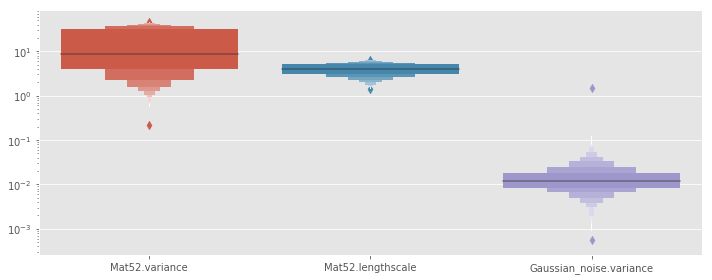

In [14]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,4))
ax.set_yscale('log')
sns.boxenplot(data=sample, ax=ax)
ax.set_xticklabels(param_name)
fig.tight_layout()

EAP推定量を代入した結果は以下の通り

 /anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


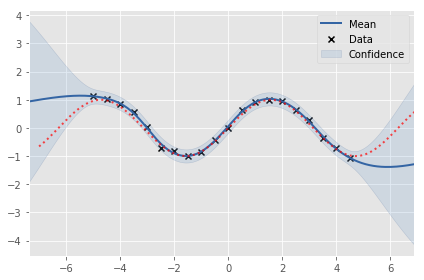

In [15]:
for ii in range(len(param_name)):
    gpmodel[param_name[ii]] = np.mean(sample, axis=0)[ii]
gpmodel.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

# 5. plot

## 5.1. plot()
- 通常のplotでは、デフォルトで95%予測区間が表示される。これを変更するには、引数lowerとupperを指定すれば良い(0~100)。
- 入力が２次元なら、projection="3d"で３次元グラフにできる。

 /anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


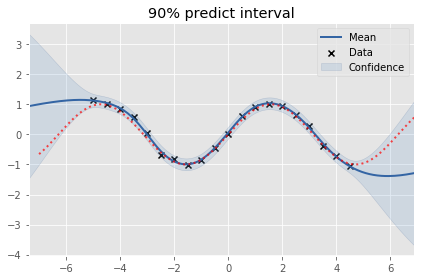

In [16]:
gpmodel.plot(lower=5, upper=95)
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.title('90% predict interval')
plt.tight_layout()

その他の引数に関しては<https://gpy.readthedocs.io/en/deploy/GPy.plotting.gpy_plot.html#module-GPy.plotting.gpy_plot.gp_plots>を参照。　　

個々の要素を個別にプロットする関数も用意されている。  
例えば予測区間なら

 /anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


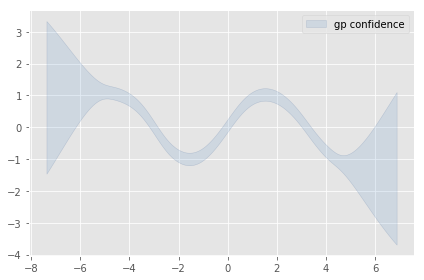

In [17]:
gpmodel.plot_confidence(lower=5, upper=95)
plt.tight_layout()

## 5.2. posterior_samples_f
- GPから(その実現値としての)関数をサンプリングする関数
  - 紛らわしい名前の"posterior_samples"も存在するが、内部で"posterior_samples_f"を呼び出している模様。

(-1.6, 1.6)

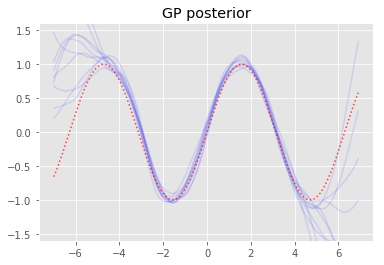

In [22]:
X_new = np.arange(-7,7,0.1)

fig, ax1 = plt.subplots(1, 1)
ax1.plot(X_new, gpmodel.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10), color="b", alpha=0.1)
#ax1.plot(X, Y , marker="o", color="r", linestyle="")
ax1.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7)
ax1.set_title('GP posterior')
ax1.set_ylim([-1.6, 1.6])